<a href="https://colab.research.google.com/github/dolmani38/non-linear-regression/blob/master/Regession_test_0809.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
!pip install lime

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Input, Embedding, Dense
from keras.models import Model
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lime import lime_tabular, lime_text
from keras.utils import to_categorical
import datetime
import random

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')

np.random.seed(1234567890)

from keras import backend as K

def r2(y_true, y_pred):
    """
    # custom R2-score metrics for keras backend
    :param y_true: 실측 데이터
    :param y_pred: 모델에 의한 예측 데이테
    :return: R^2 value, 이 값이 높다고 (예:0.99)해서 예측 값이 정확 하다고 할 수 는 없음...
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

def soft_500_acc(y_true, y_pred):
    delta = 500
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1000_acc(y_true, y_pred):
    delta = 1000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_10000_acc(y_true, y_pred):
    delta = 10000
    return K.mean(K.less_equal(K.abs(y_true-y_pred),delta))

def soft_1perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_5perc_acc(y_true, y_pred):
    delta = 0.05
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def soft_10perc_acc(y_true, y_pred):
    delta = 0.10
    return K.mean(K.less_equal(K.abs((y_true-y_pred)/y_true),delta))

def structure(df):
    """
    DataFrame의 column 등 전반적인 구조를 표출 한다.
    :param df:
    :return:
    """
    df1 = df.describe(include='all').T
    df1['type'] = df.dtypes
    df1['null count'] = df.isnull().sum()
    if 'freq' in df1.columns:
        df2 = df1[
            ['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top',
             'freq']]
    else:
        df2 = df1[['type', 'count', 'null count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]

    return df2

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values
            
class VerboseCallback(keras.callbacks.Callback):
    """
    kerase.model.fit 함수에서, log 출력을 위한 callback
    """
    def __init__(self, epoch):
        self.epoch = epoch
        self.progress("learning:", 0, [])

    def progress(self, text, current=0, log=None):
        g = self.epoch - current
        f = 50 / self.epoch
        c = int(current * f)
        pg = ['=' for i in range(c)] + ['.' for i in range(50 - c)]
        print("\r" + str(text) + "{}/{}[{}]{}".format(current, self.epoch, ''.join(pg), ('' if log is None else str(log).strip())),
              end="", flush=True)
        if self.epoch - current == 0:
            print("")

    def on_epoch_end(self, epoch, logs=None):
        self.progress("learning:", epoch + 1, logs)


class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0    

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - %s" % (self.epochs, str(logs)))

periodic_logger_10 = PeriodicLogger(10) 
periodic_logger_50 = PeriodicLogger(50)
periodic_logger_250 = PeriodicLogger(250)
periodic_logger_1000 = PeriodicLogger(1000)

## 성립 실험을 위한 시뮬레이션 데이터 생성

In [220]:
def nafyc_func(row):
    code,real_yy,rate = row['CODE'],row['REAL_YY'],row['COM_RATE']
    return real_yy * rate

In [221]:
def create_samples(n_samples):
    rate_table = {}
    samples = []
    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,500))
      for j in range(count):
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) * 10
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]
        samples.append([code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CODE','REAL_YY','COM_RATE'])

In [222]:
dataset = create_samples(n_samples=1000)
dataset['NAFYC'] = dataset.apply(nafyc_func, axis=1)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,1313280,0.26,341452.8
1,1000,2978170,0.26,774324.2
2,1000,89880,0.26,23368.8
3,1000,2418000,0.26,628680.0
4,1000,55880,0.26,14528.8
...,...,...,...,...
131125,1519,7337920,0.01,73379.2
131126,1519,1588840,0.01,15888.4
131127,1519,2178330,0.01,21783.3
131128,1519,292560,0.01,2925.6


## 성립 데이터 EDA

In [227]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,131130.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1227.0,498.0
REAL_YY,int64,131130.0,0,2.498980e+06,2.201560e+06,80.00,677850.00,1864475.00,3814985.000,9960040.00,NaN,NaN,NaN
COM_RATE,float64,131130.0,0,5.119459e-01,2.898402e-01,0.01,0.26,0.53,0.780,0.99,NaN,NaN,NaN
NAFYC,float64,131130.0,0,1.278487e+06,1.483199e+06,7.80,208471.70,707157.20,1827016.475,9634105.60,NaN,NaN,NaN


In [228]:
dataset = dataset.astype({"CODE": object})

In [229]:
structure(dataset)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CODE,object,131130.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520.0,1227.0,498.0
REAL_YY,int64,131130.0,0,2.498980e+06,2.201560e+06,80.00,677850.00,1864475.00,3814985.000,9960040.00,NaN,NaN,NaN
COM_RATE,float64,131130.0,0,5.119459e-01,2.898402e-01,0.01,0.26,0.53,0.780,0.99,NaN,NaN,NaN
NAFYC,float64,131130.0,0,1.278487e+06,1.483199e+06,7.80,208471.70,707157.20,1827016.475,9634105.60,NaN,NaN,NaN


In [230]:
dataset[dataset['CODE'] == 1386]

,CODE,REAL_YY,COM_RATE,NAFYC
96033,1386,3773070,0.89,3358032.3
96034,1386,1410640,0.89,1255469.6
96035,1386,3025750,0.89,2692917.5
96036,1386,1135880,0.89,1010933.2
96037,1386,3097400,0.89,2756686.0
...,...,...,...,...
96320,1386,860200,0.89,765578.0
96321,1386,42240,0.89,37593.6
96322,1386,7664700,0.89,6821583.0
96323,1386,4104000,0.89,3652560.0


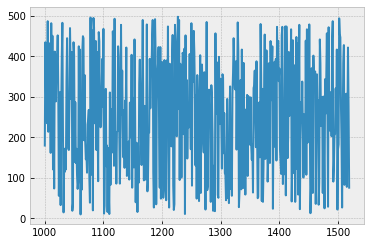

In [231]:
plt.plot(dataset.groupby('CODE')['CODE'].count())

## 성립데이터 전처리

In [232]:
# zscore norm

ds = dataset[['REAL_YY','COM_RATE']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset.update(ds)
dataset

,CODE,REAL_YY,COM_RATE,NAFYC
0,1000,-0.538573,-0.869258,341452.8
1,1000,0.217659,-0.869258,774324.2
2,1000,-1.094270,-0.869258,23368.8
3,1000,-0.036783,-0.869258,628680.0
4,1000,-1.109713,-0.869258,14528.8
...,...,...,...,...
131125,1519,2.197960,-1.731802,73379.2
131126,1519,-0.413407,-1.731802,15888.4
131127,1519,-0.145647,-1.731802,21783.3
131128,1519,-1.002208,-1.731802,2925.6


In [233]:
code_mapping = EmbeddingMapping(dataset['CODE'])
dataset = dataset.assign(code_mapping=dataset['CODE'].apply(code_mapping.get_mapping))
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,-0.538573,-0.869258,341452.8,1
1,1000,0.217659,-0.869258,774324.2,1
2,1000,-1.094270,-0.869258,23368.8,1
3,1000,-0.036783,-0.869258,628680.0,1
4,1000,-1.109713,-0.869258,14528.8,1
...,...,...,...,...,...
131125,1519,2.197960,-1.731802,73379.2,520
131126,1519,-0.413407,-1.731802,15888.4,520
131127,1519,-0.145647,-1.731802,21783.3,520
131128,1519,-1.002208,-1.731802,2925.6,520


In [234]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY']]
X_val_categorical = X_val_org[['code_mapping']]


## 성립 데이터 학습 네트워크 구성 및 학습

In [236]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_27/concat:0", shape=(None, 65), dtype=float32)
Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1, 64)        33344       input_55[0][0]                   
__________________________________________________________________________________________________
input_56 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
reshape_27 (Reshape)            (None, 64)           0           embedding_27[0][0]               
___________________

## 학습 결과 확인

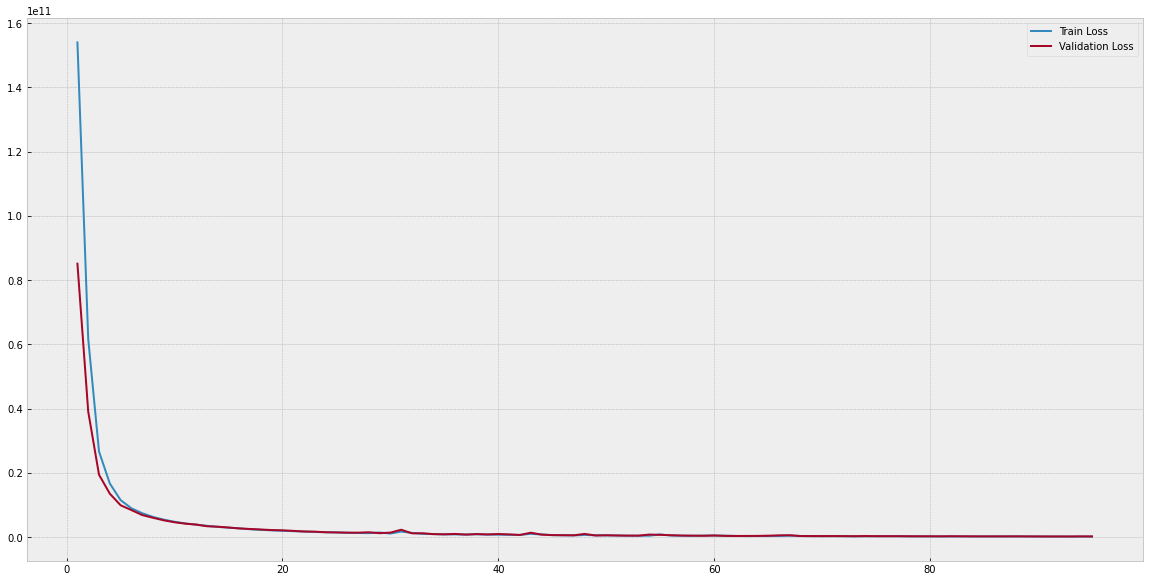

In [237]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1290759
The mean is very close to 0 (-1476.26) with std. 14749.41.


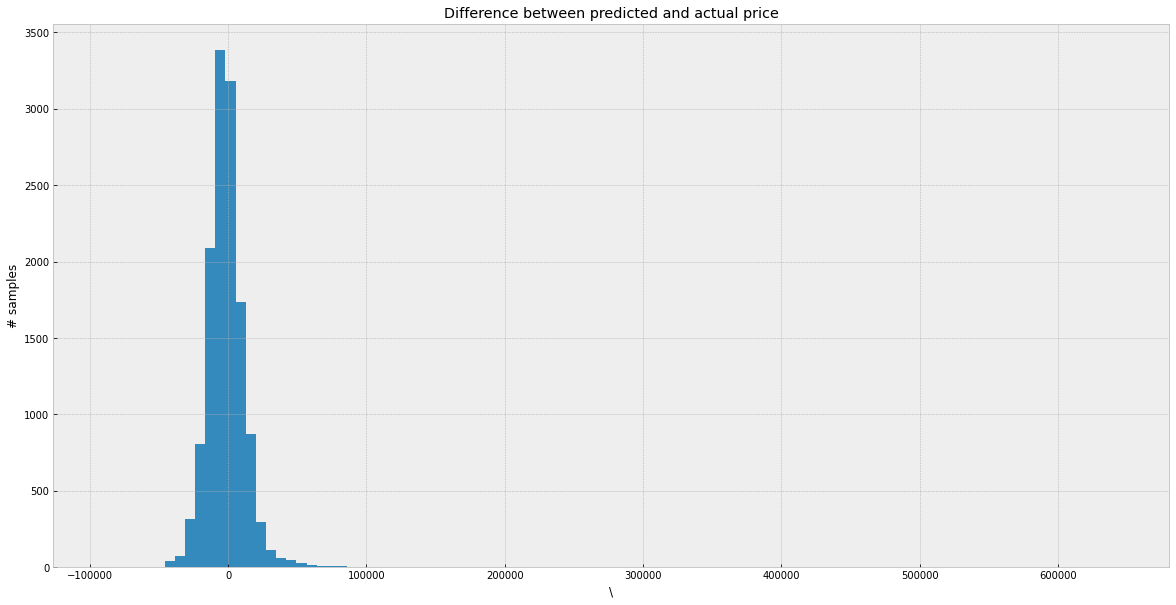

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
50236,1.824385e+06,643551.275000,643551.275000,54.499743,54.499743,1198,3.334590,-1.352283,1180833.6,199
22349,4.212468e+06,181954.300000,181954.300000,4.514420,4.514420,1085,3.330157,-0.351731,4030513.2,86
123203,6.893202e+06,116850.000000,116850.000000,1.724379,1.724379,1489,3.325742,0.614318,6776352.0,490
110935,1.153212e+06,106792.925000,106792.925000,10.205559,10.205559,1440,2.825806,-1.352283,1046419.2,441
103993,1.753928e+06,99613.800000,99613.800000,6.021456,6.021456,1413,3.285071,-1.179774,1654314.2,414
29086,5.798174e+05,98201.437500,98201.437500,20.389987,20.389987,1113,3.240130,-1.593795,481616.0,114
109775,8.998458e+05,97061.950000,97061.950000,12.090671,12.090671,1435,1.669852,-1.317781,802783.8,436
29960,3.240465e+06,94654.050000,94654.050000,3.008892,3.008892,1117,3.330221,-0.662247,3145811.2,118
97440,1.002782e+05,92400.171875,92400.171875,1172.888701,1172.888701,1391,-1.129590,0.476311,7878.0,392
114328,9.970202e+04,90025.215625,90025.215625,930.320102,930.320102,1454,-1.126956,0.096792,9676.8,455


In [238]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

In [239]:
dataset[dataset['code_mapping']==3]

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
615,1002,-0.873481,-0.351731,236143.6,3
616,1002,-1.008708,-0.351731,114082.5,3
617,1002,-0.519468,-0.351731,555689.4,3
618,1002,0.952475,-0.351731,1884323.1,3
619,1002,-0.857110,-0.351731,250920.0,3
...,...,...,...,...,...
920,1002,-0.836343,-0.351731,269665.2,3
921,1002,1.166400,-0.351731,2077420.8,3
922,1002,1.488844,-0.351731,2368471.6,3
923,1002,-1.042761,-0.351731,83344.8,3


In [240]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping
0,1000,-0.538573,-0.869258,341452.8,1
1,1000,0.217659,-0.869258,774324.2,1
2,1000,-1.094270,-0.869258,23368.8,1
3,1000,-0.036783,-0.869258,628680.0,1
4,1000,-1.109713,-0.869258,14528.8,1
...,...,...,...,...,...
131125,1519,2.197960,-1.731802,73379.2,520
131126,1519,-0.413407,-1.731802,15888.4,520
131127,1519,-0.145647,-1.731802,21783.3,520
131128,1519,-1.002208,-1.731802,2925.6,520


## 성립 데이터에 대한 파생변수 추가 실험
# NAFYC 산출 관계식에 의한 파생변수 추가 

In [241]:
dataset['ft1'] = dataset['REAL_YY']* dataset['COM_RATE']

In [242]:
dataset

,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
0,1000,-0.538573,-0.869258,341452.8,1,0.468159
1,1000,0.217659,-0.869258,774324.2,1,-0.189202
2,1000,-1.094270,-0.869258,23368.8,1,0.951202
3,1000,-0.036783,-0.869258,628680.0,1,0.031974
4,1000,-1.109713,-0.869258,14528.8,1,0.964627
...,...,...,...,...,...,...
131125,1519,2.197960,-1.731802,73379.2,520,-3.806431
131126,1519,-0.413407,-1.731802,15888.4,520,0.715939
131127,1519,-0.145647,-1.731802,21783.3,520,0.252231
131128,1519,-1.002208,-1.731802,2925.6,520,1.735625


In [243]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset[['REAL_YY','ft1','code_mapping']],
    dataset['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택
X_train_continuous = X_train_org[['REAL_YY','ft1']]
X_train_categorical = X_train_org[['code_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft1']]
X_val_categorical = X_val_org[['code_mapping']]


## 네크워크 구성 (기존과 동일) 및 학습

In [248]:
# Define the embedding input
code_input = Input(shape=(1,), dtype='int32') 
output_dim=32*2   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim,))(code_embedings)

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(5, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()

epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['code_mapping']], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical['code_mapping']], Y_val))

Tensor("concatenate_32/concat:0", shape=(None, 66), dtype=float32)
Model: "functional_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 1, 64)        33344       input_65[0][0]                   
__________________________________________________________________________________________________
input_66 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
reshape_32 (Reshape)            (None, 64)           0           embedding_32[0][0]               
___________________

## 학습 결과 확인

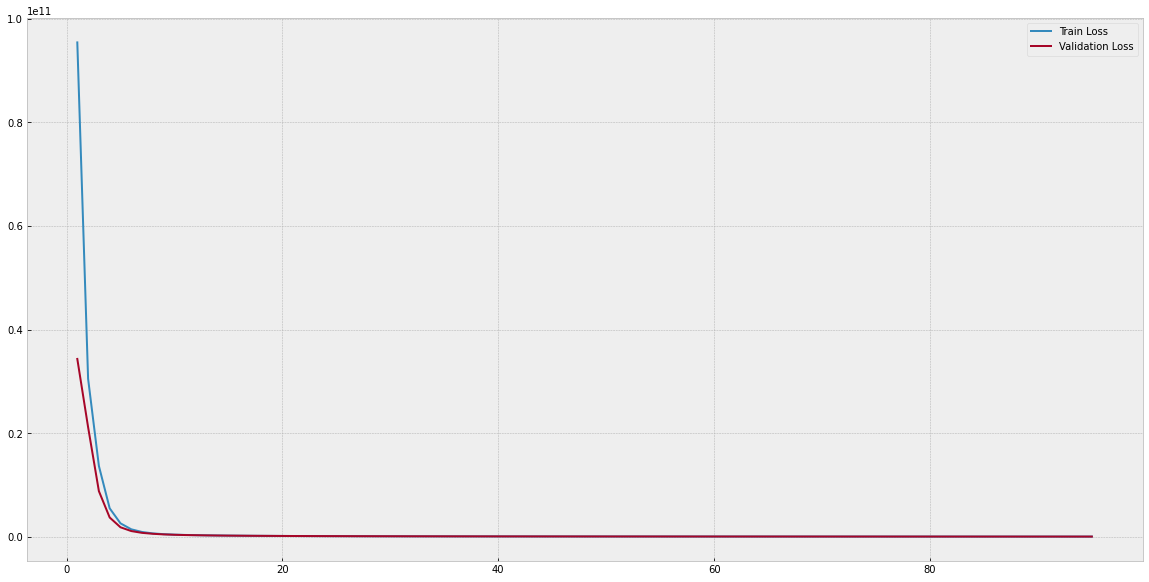

In [249]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

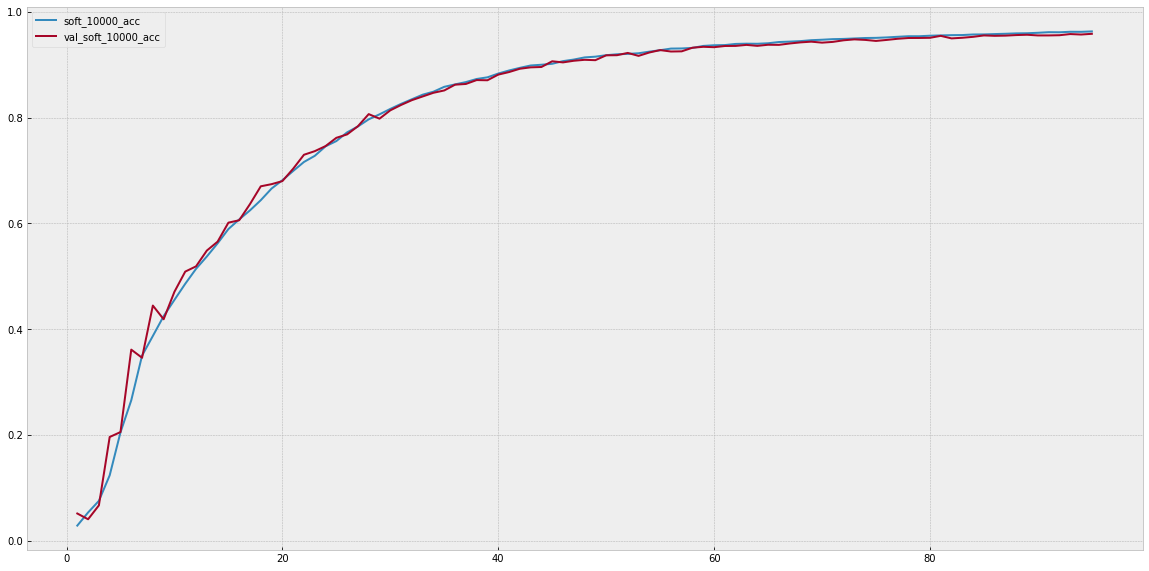

In [250]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 1316130
The mean is very close to 0 (110.05) with std. 1565.04.


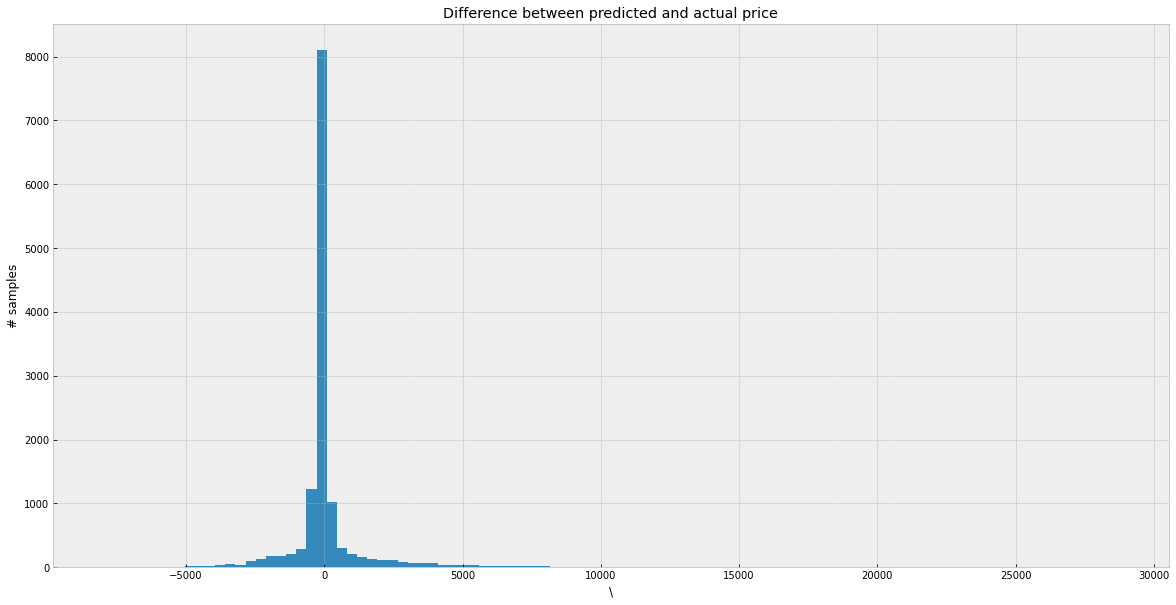

,pred,diff,abs_diff,%diff,abs_%diff,CODE,REAL_YY,COM_RATE,NAFYC,code_mapping,ft1
68226,2.872058e+04,28711.083984,28711.083984,302221.936678,302221.936678,1258,-1.135752,1.500320,9.5,259,-1.703992
119971,1.033710e+06,22392.312500,22392.312500,2.214171,2.214171,1469,2.693728,-1.379831,1011318.0,470,-3.716890
125604,6.228820e+05,21444.100000,21444.100000,3.565472,3.565472,1490,2.768394,-1.553335,601437.9,491,-4.300242
100502,1.148813e+06,20079.675000,20079.675000,1.778957,1.778957,1393,3.138335,-1.379831,1128733.2,394,-4.330373
65844,1.949768e+04,19451.681641,19451.681641,42286.264436,42286.264436,1247,-1.135666,-0.998125,46.0,248,1.133536
100237,2.335999e+06,16914.750000,16914.750000,0.729372,0.729372,1392,3.254997,-0.963424,2319084.0,393,-3.135942
111757,6.483534e+05,16097.975000,16097.975000,2.546119,2.546119,1440,2.056397,-1.483933,632255.4,441,-3.051556
108476,1.974076e+06,16054.250000,16054.250000,0.819922,0.819922,1428,2.908407,-1.032825,1958022.0,429,-3.003876
100106,2.317965e+06,15793.800000,15793.800000,0.686039,0.686039,1392,3.222975,-0.963424,2302171.2,393,-3.105092
67769,2.283136e+05,15751.578125,15751.578125,7.410345,7.410345,1256,2.083815,-1.692137,212562.0,257,-3.526101


In [ ]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['code_mapping']])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset)
b.head(10)

## lime에 의한 XAI 싷험

In [251]:
train_ds = pd.concat([X_train_continuous,X_train_categorical], axis=1)
val_ds = pd.concat([X_val_continuous,X_val_categorical], axis=1)

# XAI를 위한 lime  정의
from lime import lime_tabular, lime_text
exp = lime_tabular.LimeTabularExplainer(
    train_ds.to_numpy(),
    training_labels=Y_train,
    feature_names=train_ds.columns,
    class_names= ['NAFYC'],
    mode="regression"
)

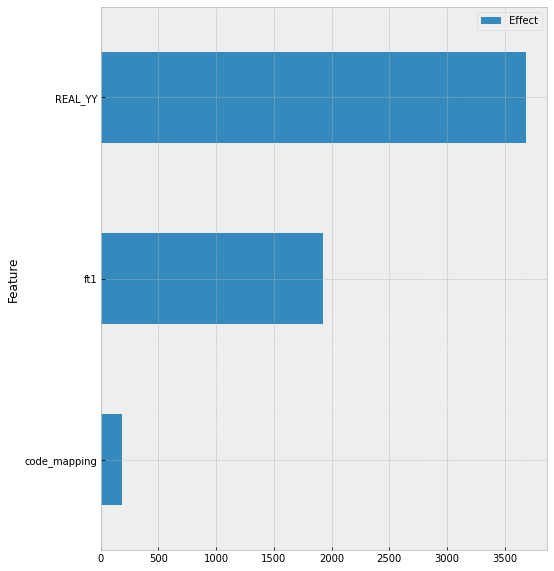

,Feature,Effect
0,code_mapping,186.249600
1,ft1,1929.124541
2,REAL_YY,3681.139030


In [252]:
# 변수의 영향력 분석
# 소팅을 위한 초기화 
exp_ana = {}
for k in train_ds.columns:
  exp_ana[k] = 0

# predict 함수 재정의 - lime에서 사용 가능하도록...
continue_dim = X_train_continuous.shape[1]
input_dim = train_ds.shape[1]
def predict(data):
    return model.predict([data[:,0:continue_dim],data[:,continue_dim:input_dim]])

# validation set의 변수 영향력 분석...
for i in range(40): #range(val_ds.shape[0]):
    p = exp.explain_instance(np.asarray(val_ds.iloc[i]),predict,num_features=val_ds.shape[1])
    for t in p.as_map()[0]:
      exp_ana[train_ds.columns[t[0]]] += np.abs(t[1])

import operator

sorted_x = sorted(exp_ana.items(), key=operator.itemgetter(1))

effect_result_table = pd.DataFrame(sorted_x,columns=['Feature', 'Effect'])
effect_result_table['Effect'] = effect_result_table['Effect']/10000
effect_result_table.plot(x='Feature',y='Effect', figsize=(8, 10),kind='barh')
plt.show()
effect_result_table

## 실효/해약 등 Event 시뮬레이션 데이터 생성

In [2]:
contract_change_rules = {
    '성립': 0,
    '실효': -0.4,
    '해약': -0.8,
    '철회': -0.5,
    '변경': -0.1
}

def create_samples2():
    rate_table = {}
    samples = []
    start_date = datetime.date(2015, 1, 1)
    end_date = datetime.date(2020, 8, 8)

    for i in range(1000,1520):
      code = i #np.random.choice(range(1000,1520))
      count = np.random.choice(range(10,250))
      for j in range(count):
        cntr_no = str(random.choice(range(100000,500000))) + ':' + str(random.choice(range(100000,500000)))
        real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
        if code not in rate_table:
          rate = np.random.choice(range(1,100)) / 100
          rate_table[code] = rate
        else:
          rate = rate_table[code]

        div = '성립'
        minus_rate = 0

        # 계약일 생성
        time_between_dates = end_date - start_date
        days_between_dates = time_between_dates.days
        random_number_of_days = random.randrange(days_between_dates)
        contract_date = start_date + datetime.timedelta(days=random_number_of_days)
        event_date = contract_date
        # 계약 총개월수 생성 
        contract_months = np.random.choice(range(12,12*30))
        event_num = 0
        samples.append([cntr_no,div,event_num,minus_rate,contract_date,contract_months,event_date,code,real_yy,rate])
        for changes in range(19):
          event_num += 1
          div = random.choice(['실효','해약','철회','변경'])
          # Event 발생일 생성 
          time_between_dates = end_date - event_date
          days_between_dates = time_between_dates.days
          random_number_of_days = random.randrange(days_between_dates)
          event_date = event_date + datetime.timedelta(days=random_number_of_days)
          if div=='변경':
            contract_date = event_date
            code = np.random.choice(range(1000,1520))
            real_yy = random.choice(range(1,1000)) * random.choice(range(1,1000)) # * 100
            contract_months = np.random.choice(range(12,12*30))       
            if code not in rate_table:
              rate = np.random.choice(range(1,100)) / 100
              rate_table[code] = rate
            else:
              rate = rate_table[code]
          elif div=='해약':
            samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
            break

          samples.append([cntr_no,div,event_num,contract_change_rules[div],contract_date,contract_months,event_date,code,real_yy,rate])
        
    return pd.DataFrame(samples, columns=['CONTRACT_ID','DIV','EVENT_NUM','MINUS_RATE','CONTRACT_DATE','CONTRACT_MONTHS','EVENT_DATE','CODE','REAL_YY','COM_RATE'])

In [190]:
dataset2 = create_samples2()

In [191]:
dataset2.head(10)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE
0,357362:372798,성립,0,0.0,2017-11-29,110,2017-11-29,1000,12232,0.35
1,357362:372798,실효,1,-0.4,2017-11-29,110,2018-10-08,1000,12232,0.35
2,357362:372798,해약,2,-0.8,2017-11-29,110,2018-12-20,1000,12232,0.35
3,406132:248688,성립,0,0.0,2018-04-21,93,2018-04-21,1000,663000,0.35
4,406132:248688,실효,1,-0.4,2018-04-21,93,2018-10-28,1000,663000,0.35
5,406132:248688,실효,2,-0.4,2018-04-21,93,2020-07-04,1000,663000,0.35
6,406132:248688,변경,3,-0.1,2020-07-06,258,2020-07-06,1080,30150,0.58
7,406132:248688,해약,4,-0.8,2020-07-06,258,2020-07-31,1080,30150,0.58
8,385793:279003,성립,0,0.0,2018-10-26,342,2018-10-26,1080,75112,0.58
9,385793:279003,실효,1,-0.4,2018-10-26,342,2019-07-06,1080,75112,0.58


In [192]:
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [193]:
back_nafyc = {}

def nafyc_func2(row):
  CONTRACT_ID = row['CONTRACT_ID']
  DIV = row['DIV']
  MINUS_RATE = row['MINUS_RATE']
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  CODE = row['CODE']
  REAL_YY = row['REAL_YY']
  COM_RATE = row['COM_RATE']
  if DIV=='성립':
    nafyc = REAL_YY * COM_RATE
    old_nafyc = 0
    back_nafyc[CONTRACT_ID] = nafyc
  else:
    nafyc = back_nafyc[CONTRACT_ID]
    old_nafyc = nafyc
    if DIV=='변경':
      nafyc = REAL_YY * COM_RATE
    else:
      # event가 발생하면 nafyc = nafyc + nafyc * (남은기간/전체기간 * 마이너스비율) --> 이건 임의도 관계식 넣은것임... 실 처리과정은 아님
      nafyc = nafyc + nafyc * MINUS_RATE * ((diff_month(EVENT_DATE,CONTRACT_DATE))/CONTRACT_MONTHS)
    back_nafyc[CONTRACT_ID] = nafyc
    #if nafyc == old_nafyc:
    #  old_nafyc = 0
  return nafyc - old_nafyc

In [194]:
dataset2['NAFYC'] = dataset2.apply(nafyc_func2, axis=1)

In [196]:
dataset2.head(20)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC
0,357362:372798,성립,0,0.0,2017-11-29,110,2017-11-29,1000,12232,0.35,4281.200000
1,357362:372798,실효,1,-0.4,2017-11-29,110,2018-10-08,1000,12232,0.35,-171.248000
2,357362:372798,해약,2,-0.8,2017-11-29,110,2018-12-20,1000,12232,0.35,-388.577280
3,406132:248688,성립,0,0.0,2018-04-21,93,2018-04-21,1000,663000,0.35,232050.000000
4,406132:248688,실효,1,-0.4,2018-04-21,93,2018-10-28,1000,663000,0.35,-5988.387097
5,406132:248688,실효,2,-0.4,2018-04-21,93,2020-07-04,1000,663000,0.35,-26252.316337
6,406132:248688,변경,3,-0.1,2020-07-06,258,2020-07-06,1080,30150,0.58,-182322.296566
7,406132:248688,해약,4,-0.8,2020-07-06,258,2020-07-31,1080,30150,0.58,0.000000
8,385793:279003,성립,0,0.0,2018-10-26,342,2018-10-26,1080,75112,0.58,43564.960000
9,385793:279003,실효,1,-0.4,2018-10-26,342,2019-07-06,1080,75112,0.58,-458.578526


## EDA 과정

In [197]:
dataset2.groupby('CONTRACT_ID').count().max()

DIV                20
EVENT_NUM          20
MINUS_RATE         20
CONTRACT_DATE      20
CONTRACT_MONTHS    20
EVENT_DATE         20
CODE               20
REAL_YY            20
COM_RATE           20
NAFYC              20
dtype: int64

## 데이터 전처리...

In [198]:
dataset2 = dataset2.astype({"CODE": object})


In [199]:
structure(dataset2)

,type,count,null count,mean,std,min,25%,50%,75%,max,unique,top,freq
CONTRACT_ID,object,325140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65219,486816:159841,20
DIV,object,325140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,변경,65232
EVENT_NUM,int64,325140,0,3.12468,3.27094,0,1,2,5,19,NaN,NaN,NaN
MINUS_RATE,float64,325140,0,-0.359553,0.287207,-0.8,-0.5,-0.4,-0.1,0,NaN,NaN,NaN
CONTRACT_DATE,object,325140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,28187
CONTRACT_MONTHS,int64,325140,0,185.403,100.378,12,98,186,272,359,NaN,NaN,NaN
EVENT_DATE,object,325140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2046,2020-08-07,45894
CODE,object,325140,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,520,1274,952
REAL_YY,int64,325140,0,250000,219692,3,67859,187593,382332,995006,NaN,NaN,NaN
COM_RATE,float64,325140,0,0.489421,0.271413,0.01,0.26,0.49,0.71,0.99,NaN,NaN,NaN


## 파생변수의 추가

In [200]:
pre_nafycs = []
pre_nafyc = 0
for row in dataset2.iterrows():
  if row[1][2] == 0:
    pre_nafycs.append(0)
    pre_nafyc = 0
  else:
    pre_nafycs.append(pre_nafyc)
    
  pre_nafyc = pre_nafyc + row[1][10]
  
dataset2['PRE_NAFYC'] = pre_nafycs

In [201]:
def last_months(row):
  CONTRACT_DATE = row['CONTRACT_DATE']
  CONTRACT_MONTHS = row['CONTRACT_MONTHS']
  EVENT_DATE = row['EVENT_DATE']
  return diff_month(EVENT_DATE,CONTRACT_DATE)

dataset2['LAST_MONTHS'] = dataset2.apply(last_months, axis=1)

In [202]:
dataset2.head(10)

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS
0,357362:372798,성립,0,0.0,2017-11-29,110,2017-11-29,1000,12232,0.35,4281.200000,0.000000,0
1,357362:372798,실효,1,-0.4,2017-11-29,110,2018-10-08,1000,12232,0.35,-171.248000,4281.200000,11
2,357362:372798,해약,2,-0.8,2017-11-29,110,2018-12-20,1000,12232,0.35,-388.577280,4109.952000,13
3,406132:248688,성립,0,0.0,2018-04-21,93,2018-04-21,1000,663000,0.35,232050.000000,0.000000,0
4,406132:248688,실효,1,-0.4,2018-04-21,93,2018-10-28,1000,663000,0.35,-5988.387097,232050.000000,6
5,406132:248688,실효,2,-0.4,2018-04-21,93,2020-07-04,1000,663000,0.35,-26252.316337,226061.612903,27
6,406132:248688,변경,3,-0.1,2020-07-06,258,2020-07-06,1080,30150,0.58,-182322.296566,199809.296566,0
7,406132:248688,해약,4,-0.8,2020-07-06,258,2020-07-31,1080,30150,0.58,0.000000,17487.000000,0
8,385793:279003,성립,0,0.0,2018-10-26,342,2018-10-26,1080,75112,0.58,43564.960000,0.000000,0
9,385793:279003,실효,1,-0.4,2018-10-26,342,2019-07-06,1080,75112,0.58,-458.578526,43564.960000,9


In [203]:
# zscore norm

ds = dataset2[['REAL_YY','PRE_NAFYC','CONTRACT_MONTHS','LAST_MONTHS']]

_mean = ds.mean(axis=0)
_std = ds.std(axis=0)

ds = ds - _mean
ds /= _std

dataset2.update(ds)
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS
0,357362:372798,성립,0,0.0,2017-11-29,-0.751191,2017-11-29,1000,-1.082280,0.35,4281.200000,-0.715793,-0.567691
1,357362:372798,실효,1,-0.4,2017-11-29,-0.751191,2018-10-08,1000,-1.082280,0.35,-171.248000,-0.683039,0.205046
2,357362:372798,해약,2,-0.8,2017-11-29,-0.751191,2018-12-20,1000,-1.082280,0.35,-388.577280,-0.684349,0.345544
3,406132:248688,성립,0,0.0,2018-04-21,-0.920551,2018-04-21,1000,1.879903,0.35,232050.000000,-0.715793,-0.567691
4,406132:248688,실효,1,-0.4,2018-04-21,-0.920551,2018-10-28,1000,1.879903,0.35,-5988.387097,1.059543,-0.146198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325135,149293:182642,변경,2,-0.1,2019-11-05,-1.428630,2019-11-05,1206,-0.703031,0.61,23166.580000,-0.447110,-0.567691
325136,149293:182642,실효,3,-0.4,2019-11-05,-1.428630,2020-03-21,1206,-0.703031,0.61,-2220.400000,-0.269870,-0.286696
325137,149293:182642,변경,4,-0.1,2020-05-24,-1.548178,2020-05-24,1076,0.544397,0.45,110254.900000,-0.286858,-0.567691
325138,149293:182642,실효,5,-0.4,2020-05-24,-1.548178,2020-06-03,1076,0.544397,0.45,-2217.600000,0.556665,-0.497443


In [204]:
#dataset2['ft1'] = dataset2['REAL_YY']* dataset2['COM_RATE']
dataset2['ft2'] = dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']
dataset2['ft3'] = dataset2['MINUS_RATE']*dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']
dataset2['ft4'] = dataset2['PRE_NAFYC']+dataset2['PRE_NAFYC']*dataset2['MINUS_RATE']*dataset2['LAST_MONTHS']/dataset2['CONTRACT_MONTHS']

In [205]:
dataset2 = dataset2.astype({"MINUS_RATE": object})
dataset2 = dataset2.astype({"COM_RATE": object})

In [206]:
dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS,ft2,ft3,ft4
0,357362:372798,성립,0,0,2017-11-29,-0.751191,2017-11-29,1000,-1.082280,0.35,4281.200000,-0.715793,-0.567691,0.755722,0.000000,-0.715793
1,357362:372798,실효,1,-0.4,2017-11-29,-0.751191,2018-10-08,1000,-1.082280,0.35,-171.248000,-0.683039,0.205046,-0.272962,0.109185,-0.757616
2,357362:372798,해약,2,-0.8,2017-11-29,-0.751191,2018-12-20,1000,-1.082280,0.35,-388.577280,-0.684349,0.345544,-0.459995,0.367996,-0.936187
3,406132:248688,성립,0,0,2018-04-21,-0.920551,2018-04-21,1000,1.879903,0.35,232050.000000,-0.715793,-0.567691,0.616687,0.000000,-0.715793
4,406132:248688,실효,1,-0.4,2018-04-21,-0.920551,2018-10-28,1000,1.879903,0.35,-5988.387097,1.059543,-0.146198,0.158816,-0.063526,0.992235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325135,149293:182642,변경,2,-0.1,2019-11-05,-1.428630,2019-11-05,1206,-0.703031,0.61,23166.580000,-0.447110,-0.567691,0.397368,-0.039737,-0.429343
325136,149293:182642,실효,3,-0.4,2019-11-05,-1.428630,2020-03-21,1206,-0.703031,0.61,-2220.400000,-0.269870,-0.286696,0.200679,-0.080272,-0.248207
325137,149293:182642,변경,4,-0.1,2020-05-24,-1.548178,2020-05-24,1076,0.544397,0.45,110254.900000,-0.286858,-0.567691,0.366684,-0.036668,-0.276339
325138,149293:182642,실효,5,-0.4,2020-05-24,-1.548178,2020-06-03,1076,0.544397,0.45,-2217.600000,0.556665,-0.497443,0.321308,-0.128523,0.485121


In [207]:
# 상품코드의 categpry mapping
code_mapping = EmbeddingMapping(dataset2['CODE'])
dataset2 = dataset2.assign(code_mapping=dataset2['CODE'].apply(code_mapping.get_mapping))
# event구분의 category mapping
div_mapping = EmbeddingMapping(dataset2['DIV'])
dataset2 = dataset2.assign(div_mapping=dataset2['DIV'].apply(div_mapping.get_mapping))
# EVENT_NUM의 category mapping
eventint_mapping = EmbeddingMapping(dataset2['EVENT_NUM'])
dataset2 = dataset2.assign(eventint_mapping=dataset2['EVENT_NUM'].apply(eventint_mapping.get_mapping))
# COM_RATE의 category mapping
comrate_mapping = EmbeddingMapping(dataset2['COM_RATE'])
dataset2 = dataset2.assign(comrate_mapping=dataset2['COM_RATE'].apply(comrate_mapping.get_mapping))
# MINUS_RATE category mapping
minusrate_mapping = EmbeddingMapping(dataset2['MINUS_RATE'])
dataset2 = dataset2.assign(minusrate_mapping=dataset2['MINUS_RATE'].apply(minusrate_mapping.get_mapping))


dataset2

,CONTRACT_ID,DIV,EVENT_NUM,MINUS_RATE,CONTRACT_DATE,CONTRACT_MONTHS,EVENT_DATE,CODE,REAL_YY,COM_RATE,NAFYC,PRE_NAFYC,LAST_MONTHS,ft2,ft3,ft4,code_mapping,div_mapping,eventint_mapping,comrate_mapping,minusrate_mapping
0,357362:372798,성립,0,0,2017-11-29,-0.751191,2017-11-29,1000,-1.082280,0.35,4281.200000,-0.715793,-0.567691,0.755722,0.000000,-0.715793,1,1,1,1,1
1,357362:372798,실효,1,-0.4,2017-11-29,-0.751191,2018-10-08,1000,-1.082280,0.35,-171.248000,-0.683039,0.205046,-0.272962,0.109185,-0.757616,1,2,2,1,2
2,357362:372798,해약,2,-0.8,2017-11-29,-0.751191,2018-12-20,1000,-1.082280,0.35,-388.577280,-0.684349,0.345544,-0.459995,0.367996,-0.936187,1,3,3,1,3
3,406132:248688,성립,0,0,2018-04-21,-0.920551,2018-04-21,1000,1.879903,0.35,232050.000000,-0.715793,-0.567691,0.616687,0.000000,-0.715793,1,1,1,1,1
4,406132:248688,실효,1,-0.4,2018-04-21,-0.920551,2018-10-28,1000,1.879903,0.35,-5988.387097,1.059543,-0.146198,0.158816,-0.063526,0.992235,1,2,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325135,149293:182642,변경,2,-0.1,2019-11-05,-1.428630,2019-11-05,1206,-0.703031,0.61,23166.580000,-0.447110,-0.567691,0.397368,-0.039737,-0.429343,452,4,3,39,4
325136,149293:182642,실효,3,-0.4,2019-11-05,-1.428630,2020-03-21,1206,-0.703031,0.61,-2220.400000,-0.269870,-0.286696,0.200679,-0.080272,-0.248207,452,2,4,39,2
325137,149293:182642,변경,4,-0.1,2020-05-24,-1.548178,2020-05-24,1076,0.544397,0.45,110254.900000,-0.286858,-0.567691,0.366684,-0.036668,-0.276339,401,4,5,26,4
325138,149293:182642,실효,5,-0.4,2020-05-24,-1.548178,2020-06-03,1076,0.544397,0.45,-2217.600000,0.556665,-0.497443,0.321308,-0.128523,0.485121,401,2,6,26,2


In [208]:
#dataset_net = dataset2[['CONTRACT_ID','REAL_YY','ft1','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping','NAFYC']]
dataset_net = dataset2[['CONTRACT_ID','REAL_YY','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping','NAFYC']]
dataset_net.shape

(325140, 12)

In [209]:
# 성립 이외의 EVENT 만 분리...

#dataset_net2 = dataset_net[(dataset_net['div_mapping']==2) || (dataset_net['div_mapping']==3) || (dataset_net['div_mapping']==4) || (dataset_net['div_mapping']==5)]
dataset_net2 = dataset_net[dataset_net['div_mapping']>1]
dataset_net2.shape

(259921, 12)

## Trainset과 Validationset의 분리  

In [214]:
# trainset과 validationset 나누고... 기타 정리

X_train_org, X_val_org, Y_train, Y_val = train_test_split(dataset_net[['CONTRACT_ID','REAL_YY','ft2','ft3','ft4','PRE_NAFYC','code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']],
    dataset_net['NAFYC'], test_size=0.1, random_state=0)

# 학습 대상 변수만 선택

X_train_continuous = X_train_org[['REAL_YY','ft2','ft3','ft4','PRE_NAFYC']]
X_train_categorical = X_train_org[['code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']]

X_val_continuous  = X_val_org[['REAL_YY','ft2','ft3','ft4','PRE_NAFYC']]
X_val_categorical = X_val_org[['code_mapping','div_mapping','eventint_mapping','comrate_mapping','minusrate_mapping']]


In [215]:
structure(X_train_continuous)

,type,count,null count,mean,std,min,25%,50%,75%,max
REAL_YY,float64,292626.0,0,0.000637,1.000452,-1.137944,-0.828520,-0.283671,0.603170,3.391136
ft2,float64,292626.0,0,0.013175,18.065877,-978.361957,-0.689901,-0.003354,0.683233,648.704129
ft3,float64,292626.0,0,0.028567,10.118889,-509.513665,-0.173462,0.000000,0.174813,782.689566
ft4,float64,292626.0,0,-0.010641,8.777010,-685.174793,-0.715793,-0.369468,0.293000,1218.335319
PRE_NAFYC,float64,292626.0,0,-0.000433,0.999212,-5.252901,-0.696184,-0.424801,0.291329,6.714908


## Network의 구성

In [216]:
import keras
from keras import Input, Model
from keras.layers import Dense, Activation, Flatten, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, concatenate

# custom R2-score metrics for keras backend
from keras import backend as K

# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))

# Define the embedding input
code_input = Input(shape=(5,), dtype='int32') 
output_dim=30   #X_train_categorical['code_mapping'].max()*1
code_embedings = Embedding(output_dim=output_dim, input_dim=X_train_categorical['code_mapping'].max()+1)(code_input)
code_embedings = keras.layers.Reshape((output_dim*5,))(code_embedings)

# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input,code_embedings])
print(all_input)

# Define the model
dense1 = Dense(all_input.shape[1]*3, activation='relu')(all_input)
dense2 = Dense(50, activation='relu')(dense1)
predictions = Dense(1)(dense2)

# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, code_input], outputs=predictions)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True),metrics=[soft_5perc_acc,soft_10000_acc,r2])
model.summary()


Tensor("concatenate_25/concat:0", shape=(None, 155), dtype=float32)
Model: "functional_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 5, 30)        15630       input_52[0][0]                   
__________________________________________________________________________________________________
input_51 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
reshape_25 (Reshape)            (None, 150)          0           embedding_25[0][0]               
__________________

In [219]:
epochs = 100

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical], Y_train, 
          epochs=epochs, batch_size=10000, 
          callbacks=[periodic_logger_10], verbose=0,
          validation_data=([X_val_continuous, X_val_categorical], Y_val))

Epoch: 10 - {'loss': 86231048.0, 'soft_5perc_acc': 0.32646164298057556, 'soft_10000_acc': 0.9307874441146851, 'r2': 0.9940356612205505, 'val_loss': 262818352.0, 'val_soft_5perc_acc': 0.3260883390903473, 'val_soft_10000_acc': 0.9133997559547424, 'val_r2': 0.9815248847007751}
Epoch: 20 - {'loss': 85284168.0, 'soft_5perc_acc': 0.3282473683357239, 'soft_10000_acc': 0.930707573890686, 'r2': 0.9941352605819702, 'val_loss': 267467360.0, 'val_soft_5perc_acc': 0.32521334290504456, 'val_soft_10000_acc': 0.9119308590888977, 'val_r2': 0.9811075925827026}
Epoch: 30 - {'loss': 83727360.0, 'soft_5perc_acc': 0.33348214626312256, 'soft_10000_acc': 0.933830201625824, 'r2': 0.9942893981933594, 'val_loss': 260863056.0, 'val_soft_5perc_acc': 0.33048057556152344, 'val_soft_10000_acc': 0.9169486165046692, 'val_r2': 0.9816369414329529}
Epoch: 40 - {'loss': 83252192.0, 'soft_5perc_acc': 0.3332046568393707, 'soft_10000_acc': 0.9353386759757996, 'r2': 0.9942187070846558, 'val_loss': 263713744.0, 'val_soft_5perc_

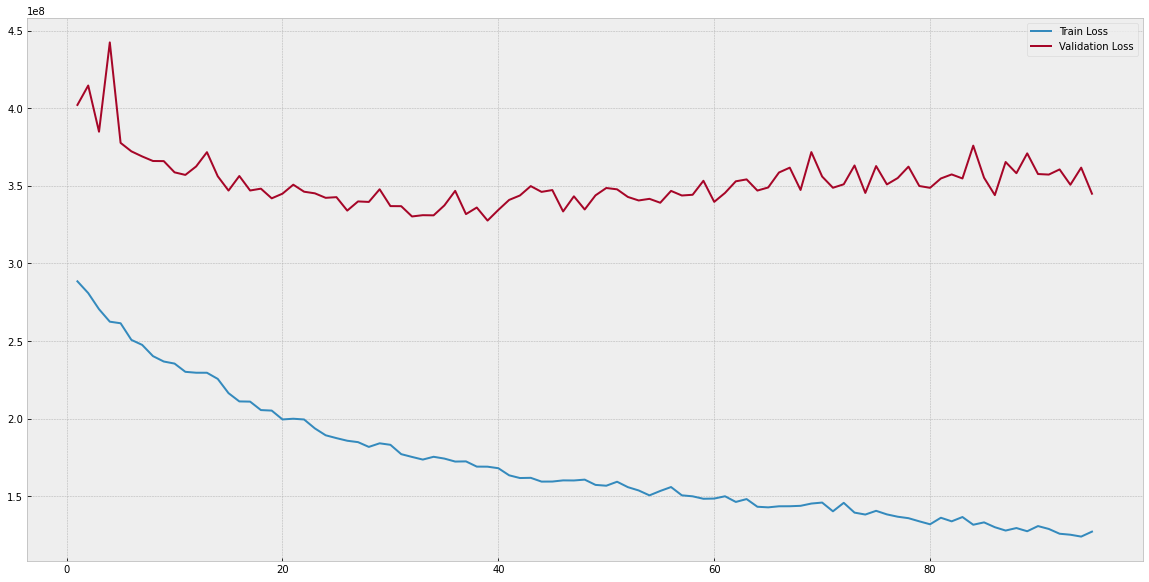

In [174]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][5:]
_val_loss = history.history['val_loss'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

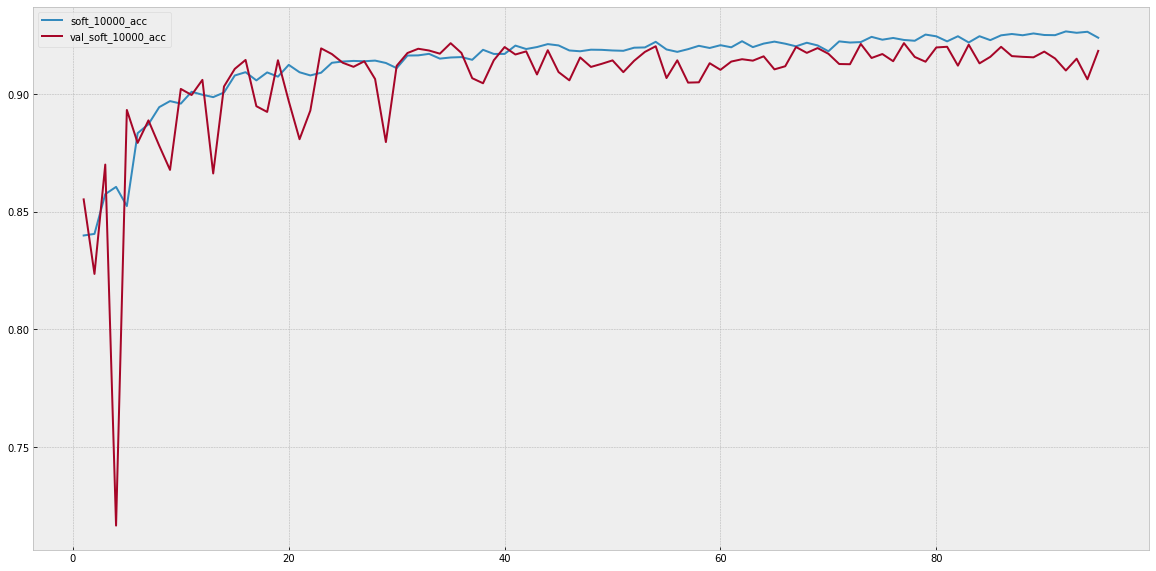

In [175]:
plt.figure(figsize=(20,10))
_loss = history.history['soft_10000_acc'][5:]
_val_loss = history.history['val_soft_10000_acc'][5:]

train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='soft_10000_acc')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='val_soft_10000_acc')

_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

This is the average value we are trying to predict: 20460
The mean is very close to 0 (762.62) with std. 18558.96.


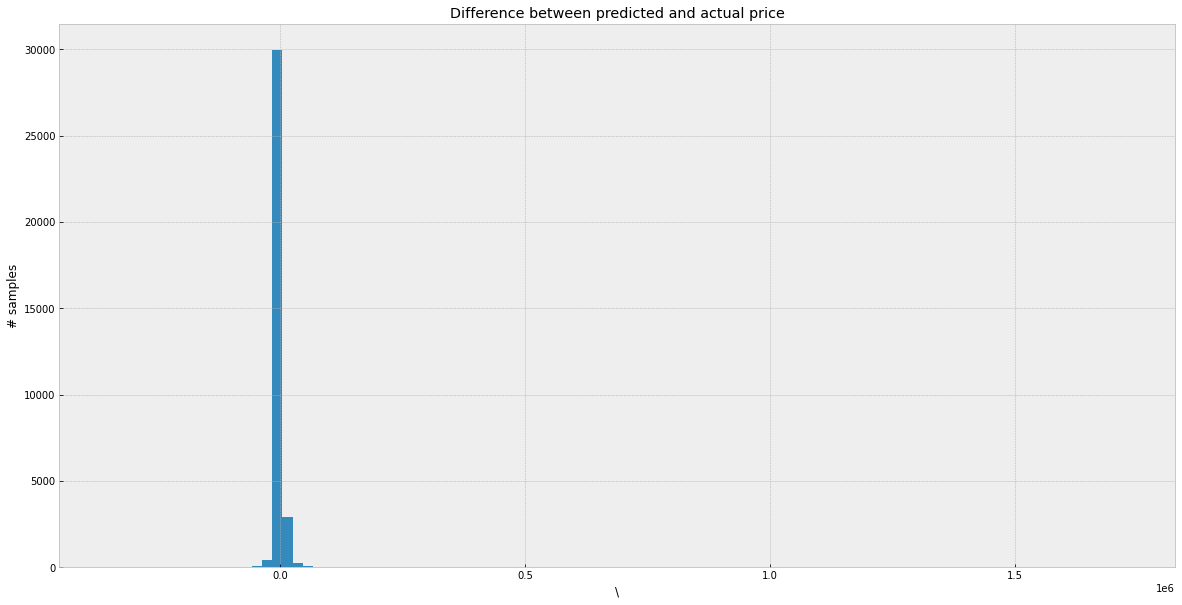

,NAFYC,pred,abs_diff,abs_%diff,DIV
37349,-1.833536e+06,-109102.273438,1.724434e+06,94.049626,해약
182131,-8.745186e+05,-57496.750000,8.170219e+05,93.425326,해약
247340,-7.000646e+05,-23430.546875,6.766341e+05,96.653088,해약
297880,-6.633677e+05,-87.647858,6.632800e+05,99.986787,실효
12457,-6.702787e+05,-22373.423828,6.479052e+05,96.662071,해약
200194,-7.856879e+05,-176108.187500,6.095797e+05,77.585477,해약
198425,-4.647133e+05,-14813.807617,4.498995e+05,96.812270,철회
305133,-4.887919e+05,-41417.519531,4.473744e+05,91.526553,해약
238214,-4.410828e+05,-13302.280273,4.277805e+05,96.984176,해약
266194,-4.546149e+05,-28923.404297,4.256915e+05,93.637823,실효


In [176]:
df = pd.DataFrame(Y_val,columns=['NAFYC'])

print ("This is the average value we are trying to predict: %d" % df['NAFYC'].mean())

# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical])

# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['NAFYC']

# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])

# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['NAFYC'])

# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2), std=round(diff_std, 2)))

# Here is the histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("\\")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")

plt.show()

# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
a = df.sort_values("abs_diff", ascending=False)
a.drop(columns=['NAFYC'],inplace=True)
b = a.join(dataset2)[['NAFYC','pred','abs_diff','abs_%diff','DIV']]
b.head(10)